In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import sys
import os
sys.path.append('..')

In [12]:
import argparse
from options.train_audio2feature_options import TrainOptions
from models import networks

parser = argparse.ArgumentParser()
to = TrainOptions()
# --continue_train --load_epoch 0 --epoch_count 0
# --dataroot ../data
args_raw = '--task Audio2Feature --model audio2feature --dataset_mode audiovisual --name Audio2Feature --gpu_ids 0 \
    --dataset_names common_voice --dataroot ../data \
    --frame_jump_stride 4 --num_threads 0 --batch_size 32 --serial_batches \
    --audio_encoder APC --feature_decoder LSTM --loss L2 --sequence_length 240 --FPS 60 --sample_rate 16000 \
    --audioRF_history 60 --audioRF_future 0 --feature_dtype pts3d --ispts_norm 1 --use_delta_pts 1 --frame_future 18 \
    --predict_length 1 --only_mouth 1 --verbose --suffix vic \
    --save_epoch_freq 5 --save_by_iter --phase train --re_transform 0 \
    --train_dataset_names train_list.txt --validate_dataset_names val_list.txt \
    --n_epochs 200 --lr_policy linear --lr 1e-4 --lr_final 1e-5 --n_epochs_decay 200 \
    --validate_epoch 10 --loss_smooth_weight 0 --optimizer Adam'
args_raw = args_raw.split(' ')
args = []
for x in args_raw:
    if len(x.strip()) > 0:
        args.append(x)
#opt = to.gather_options(args=args)
opt = to.parse(args=args)

#--frame_jump_stride, --feature_decoder, --feature_dtype, --frame_future

opt: Namespace(A2L_GMM_ndim=75, APC_frame_history=0, APC_hidden_size=512, APC_residual=False, APC_rnn_layers=3, FPS='60', LSTM_dropout=0, LSTM_hidden_size=256, LSTM_layers=3, LSTM_output_size=80, LSTM_residual=False, LSTM_sequence_length=60, audioRF_future=0, audioRF_history=60, audio_encoder='APC', batch_size=32, checkpoints_dir='./checkpoints/', continue_train=False, dataroot='../data', dataset_mode='audiovisual', dataset_names='common_voice', epoch_count=0, feature_decoder='LSTM', feature_dtype='pts3d', frame_future=18, frame_jump_stride=4, gamma=0.2, gaussian_noise=1, gaussian_noise_scale=0.01, gpu_ids='0', ispts_norm=1, load_epoch='200', loss='L2', loss_smooth_weight=0.0, lr=0.0001, lr_decay_iters=250, lr_final=1e-05, lr_policy='linear', max_dataset_size=inf, model='audio2feature', n_epochs=200, n_epochs_decay=200, name='Audio2Feature', num_threads=0, only_mouth=1, optimizer='Adam', phase='train', predict_length=1, re_transform=0, sample_rate=16000, save_by_iter=True, save_epoch_f

In [13]:
from models import audio2feature
Audio2Feature = networks.init_net(audio2feature.Audio2Feature(opt), init_type='normal', init_gain=0.02, gpu_ids=opt.gpu_ids)

optimizer = torch.optim.Adam([{'params': Audio2Feature.parameters(),
                                                'initial_lr': opt.lr}], lr=opt.lr, betas=(0.9, 0.999))

initialize network with normal


200
200


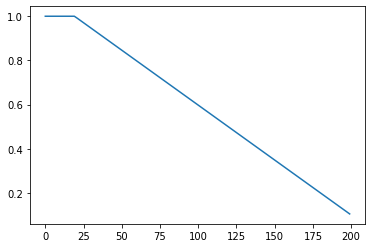

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
def lambda_rule(epoch):
    min_scale = opt.lr_final / opt.lr
    lr_l = np.clip((opt.n_epochs - epoch) / float(opt.n_epochs_decay + 1), 0, 1.0 - min_scale) + min_scale
    return lr_l
print(opt.n_epochs)
print(opt.n_epochs_decay)
epochs = np.arange(0, 200)
lrs = []
for epoch in epochs:
    lr = lambda_rule(epoch)
    lrs.append(lr)
plt.plot(epochs, lrs)

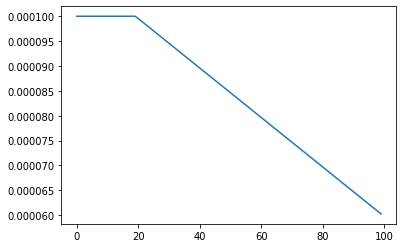

In [17]:
# Assuming optimizer has two groups.
lambda1 = lambda epoch: epoch // 30
lambda2 = lambda epoch: 0.95 ** epoch
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=[lambda_rule])
lrs = []
for epoch in range(100):
    #train(...)
    #validate(...)
    lr = scheduler.get_lr()
    lrs.append(lr)
    scheduler.step()
plt.plot(lrs)